In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
initial_size = (20, 20)
output_size = (50, 50)

(0.0, 1.0)

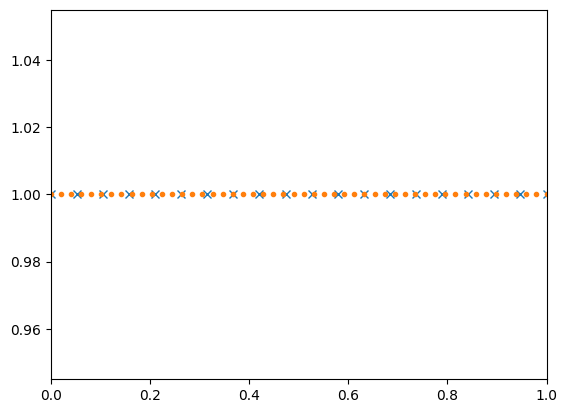

In [3]:
coordinates = np.linspace(0, 1, 20)

new_coordinates = np.linspace(0, 1, 50)

plt.plot(coordinates, np.ones_like(coordinates), 'x')

plt.plot(new_coordinates, np.ones_like(new_coordinates), '.')
plt.xlim([0,1])

In [4]:
import torch
def make_coord(shape, ranges=None, flatten=True):
    """ Make coordinates at grid centers.
    """
    coord_seqs = []
    for i, n in enumerate(shape):
        if ranges is None:
            v0, v1 = -1, 1
        else:
            v0, v1 = ranges[i]
        r = (v1 - v0) / (2 * n)
        seq = v0 + r + (2 * r) * torch.arange(n).float()
        coord_seqs.append(seq)
    ret = torch.stack(torch.meshgrid(*coord_seqs), dim=-1)
    if flatten:
        ret = ret.view(-1, ret.shape[-1])
    return ret

make_coord([3,3])

/home/davton/.local/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/davton/miniconda3/envs/thesis/lib/python3.9/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


tensor([[-0.6667, -0.6667],
        [-0.6667,  0.0000],
        [-0.6667,  0.6667],
        [ 0.0000, -0.6667],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.6667],
        [ 0.6667, -0.6667],
        [ 0.6667,  0.0000],
        [ 0.6667,  0.6667]])

In [5]:
def generate_upsampling_vectors(start_resolution: tuple[int, int], end_resolution: tuple[int, int]) -> list[tuple[tuple[int, int], tuple[float, float]]]:
    # For each start resolution pixel, output the vector to the nearest end pixels

    start_coords = make_coord(start_resolution)
    print(start_coords)
    for end_x, end_y in make_coord(end_resolution):
        

        print(end_x, end_y)            


    pass

generate_upsampling_vectors([3,3], [5,5])

tensor([[-0.6667, -0.6667],
        [-0.6667,  0.0000],
        [-0.6667,  0.6667],
        [ 0.0000, -0.6667],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.6667],
        [ 0.6667, -0.6667],
        [ 0.6667,  0.0000],
        [ 0.6667,  0.6667]])
tensor(-0.8000) tensor(-0.8000)
tensor(-0.8000) tensor(-0.4000)
tensor(-0.8000) tensor(0.)
tensor(-0.8000) tensor(0.4000)
tensor(-0.8000) tensor(0.8000)
tensor(-0.4000) tensor(-0.8000)
tensor(-0.4000) tensor(-0.4000)
tensor(-0.4000) tensor(0.)
tensor(-0.4000) tensor(0.4000)
tensor(-0.4000) tensor(0.8000)
tensor(0.) tensor(-0.8000)
tensor(0.) tensor(-0.4000)
tensor(0.) tensor(0.)
tensor(0.) tensor(0.4000)
tensor(0.) tensor(0.8000)
tensor(0.4000) tensor(-0.8000)
tensor(0.4000) tensor(-0.4000)
tensor(0.4000) tensor(0.)
tensor(0.4000) tensor(0.4000)
tensor(0.4000) tensor(0.8000)
tensor(0.8000) tensor(-0.8000)
tensor(0.8000) tensor(-0.4000)
tensor(0.8000) tensor(0.)
tensor(0.8000) tensor(0.4000)
tensor(0.8000) tensor(0.8000)


In [6]:
def generate_coords(resolution: int):
    return np.linspace(0,1,resolution+1)[1:] - 1/(2*resolution)

start_resolution = 4
end_resolution = 5

start_coords = generate_coords(start_resolution)
end_coords = generate_coords(end_resolution)
# coords = [0.25, 0.5, 0.75]

assignments = []
second_assignments = []
distances = []
next_distances = []

for coord in end_coords:
    nearest_pixel = int(np.floor(coord*start_resolution))
    vector_to_nearest_pixel = coord - start_coords[nearest_pixel]
    next_nearest_pixel = nearest_pixel + 1 if vector_to_nearest_pixel > 0 else nearest_pixel - 1

    assignments.append(nearest_pixel)
    second_assignments.append(next_nearest_pixel)
    distances.append(vector_to_nearest_pixel)
    next_distances.append(coord - start_coords[next_nearest_pixel] if next_nearest_pixel in range(start_resolution) else None)
    

print(start_coords)
print(end_coords)

print(assignments)
print(second_assignments)
print(distances)
print(next_distances)

[0.125 0.375 0.625 0.875]
[0.1 0.3 0.5 0.7 0.9]
[0, 1, 2, 2, 3]
[-1, 0, 1, 3, 4]
[-0.024999999999999994, -0.07499999999999996, -0.12499999999999989, 0.07500000000000007, 0.025000000000000022]
[None, 0.17500000000000004, 0.1250000000000001, -0.17499999999999993, None]


In [19]:
from itertools import product
from jaxtyping import Float
import numpy as np

def generate_coords_2d(resolution: tuple[int, int]) -> Float[np.ndarray, "X Y 2"]:
    a = np.linspace(0,1,resolution[0])
    b = np.linspace(0,1,resolution[1])
    A, B = np.meshgrid(a, b)

    # Flatten the arrays and pair them
    return np.array([A, B]).T

start_resolution = np.array([2,3])
end_resolution = np.array([4,5])
start_coords = generate_coords_2d(start_resolution)
end_coords = generate_coords_2d(end_resolution)

corner_pixels = np.zeros((4, *end_resolution, 2))

skipped_coordinates = []

for i_end, j_end in product(range(end_resolution[0]), range(end_resolution[1])):
    end_coord = end_coords[i_end, j_end]
    first_corner = np.floor(end_coord*start_resolution).astype(int)
    first_corner = np.clip(first_corner, 0, start_resolution-1)

    vector_from_nearest_corner = end_coord - start_coords[first_corner[0], first_corner[1]]
    # next_x, next_y = (vector_from_nearest_start_to_end > 0)*2-1
    # if nearest_pixel[0] + next_x not in range(end_resolution[0]) or nearest_pixel[1] + next_y not in range(end_resolution[1]):
    #     continue
    corner_pixels[0, i_end, j_end] = first_corner
    corner_pixels[1, i_end, j_end] = np.array([first_corner[0]+1, first_corner[1]])
    corner_pixels[2, i_end, j_end] = np.array([first_corner[0], first_corner[1]+1])
    corner_pixels[3, i_end, j_end] = np.array([first_corner[0]+1, first_corner[1]+1])

# I want to output a vector a = [2,4,x,y] (dim, n_nearest, i_x, i_y) containing 
# all the assigned pixel indices, so that i can do latent_code[:, t, a[0], a[1]] 
# and get a tensor c of shape [C,4,x,y] of all the codes that I need. Then, I 
# need a tensor of vectors to those assigned indices, again of shape [2, i], that 
# I can concatenate it with c and get a tensor [C+2, I]. Then I also append tau 
# (which is constant across all Is) to get [C+3, I] which I can then run through 
# the decoding network
corner_pixels.shape
corner_pixels = corner_pixels.astype(int)

In [20]:
latent_code = np.random.rand(8, 4, 5)
latent_code[:, corner_pixels[0], corner_pixels[1]].shape

(8, 4, 5, 2)

In [16]:
from jaxtyping import Int, Bool, Float
from itertools import product

def get_upscaling_pixel_indices_and_distances_old(
    start_resolution: tuple[int, int], end_resolution: tuple[int, int]
) -> tuple[Int[np.ndarray, "4 XUpscaled YUpscaled 2"], Float[np.ndarray, "4 XUpscaled YUpscaled 2"], Bool[np.ndarray, "4 XUpscaled YUpscaled"]]:
    start_coords = generate_coords_2d(start_resolution)
    end_coords = generate_coords_2d(end_resolution)
    start_resolution = np.array(start_resolution, dtype=int)


    corner_pixels = np.zeros((4, *end_resolution, 2), dtype=int)

    for i_end, j_end in product(range(end_resolution[0]), range(end_resolution[1])):
        end_coord = end_coords[i_end, j_end]
        first_corner = np.floor(end_coord*(start_resolution-1)).astype(int)
        # Force end_pixels placed exactly on the edge to instead use pixel inside image as first corner
        first_corner = np.clip(first_corner, 0, start_resolution-2)
        corner_pixels[0, i_end, j_end] = first_corner
        corner_pixels[1, i_end, j_end] = np.array([first_corner[0]+1, first_corner[1]])
        corner_pixels[2, i_end, j_end] = np.array([first_corner[0], first_corner[1]+1])
        corner_pixels[3, i_end, j_end] = np.array([first_corner[0]+1, first_corner[1]+1])

    
    nearest_start_coords = start_coords[corner_pixels[..., 0], corner_pixels[..., 1]]
    corner_to_point_vectors = end_coords[None, :] - nearest_start_coords

    return corner_pixels, corner_to_point_vectors

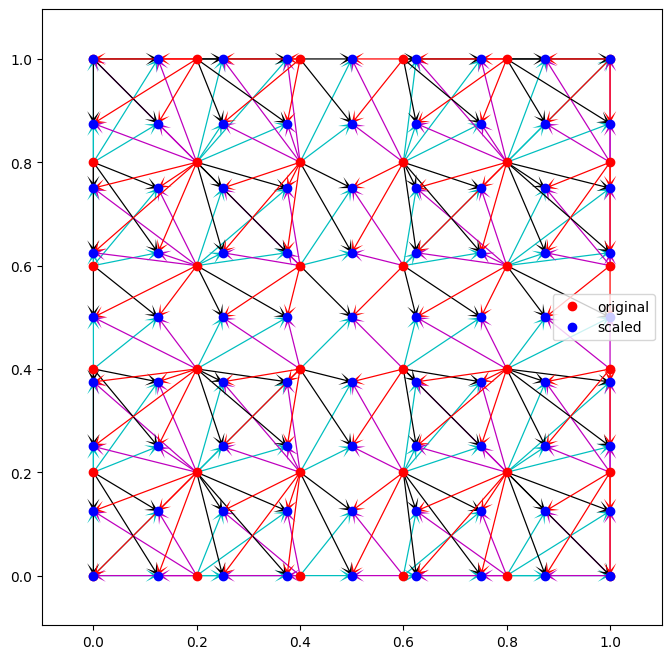

In [14]:
from matplotlib import pyplot as plt
from dynamic_fusion.utils.superresolution import get_upscaling_pixel_indices_and_distances, generate_coords_2d
import numpy as np

start_resolution = (6,6)
end_resolution = (9,9)
nearest, vectors = get_upscaling_pixel_indices_and_distances(start_resolution, end_resolution)
start_coords = generate_coords_2d(start_resolution)
end_coords = generate_coords_2d(end_resolution)

flat_start = np.reshape(start_coords, (-1, 2))
flat_end = np.reshape(end_coords, (-1, 2))
plt.figure(0, (8,8))

plt.plot(flat_start[:, 0], flat_start[:,1], 'or', label='original')
plt.plot(flat_end[:, 0], flat_end[:,1], 'ob', label='scaled')
plt.legend()

colors = ['c', 'm', 'k', 'r']

for i, (index, vector, color) in enumerate(zip(nearest, vectors, colors)):
    current_start_coord = start_coords[index[..., 0], index[..., 1]]
    
    plt.quiver(current_start_coord[..., 0], current_start_coord[..., 1], vector[..., 0], vector[..., 1], scale=1, scale_units='xy', color=color, width=0.002, headwidth=10,headlength=10)
    if i > 2:
        break
plt.axis('equal')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.show()

In [18]:
start_resolution = (96, 96)
end_resolution = (384, 384)


In [21]:
%%timeit
nearest, vectors = get_upscaling_pixel_indices_and_distances(start_resolution, end_resolution)


82.8 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [22]:
%%timeit
nearest, vectors = get_upscaling_pixel_indices_and_distances_old(start_resolution, end_resolution)


836 ms ± 7.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%%timeit
nearest, vectors = get_upscaling_pixel_indices_and_distances_newest(start_resolution, end_resolution)

14.3 ms ± 770 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [50]:
from typing import Tuple
from numba import jit
import torch

def find_nearest_pixels_new(
    start_resolution: Int[np.ndarray, " 2"],
    end_resolution: Tuple[int, int],
    end_coords: Float[np.ndarray, "X Y 2"],
) -> Int[np.ndarray, "4 XUpscaled YUpscaled 2"]:
    corner_pixels = np.zeros((4, *end_resolution, 2), dtype=np.int64)
    two_zeros = np.zeros(2, dtype=np.float64)
    start_resolution = start_resolution.astype(np.float64)

    first_corners = np.floor(end_coords * (start_resolution - 1))
    first_corners = np.clip(first_corners, two_zeros, start_resolution - 2)
    corner_pixels[0] = first_corners
    corner_pixels[1] = first_corners + np.array([1,0])
    corner_pixels[2] = first_corners + np.array([0, 1])
    corner_pixels[3] = first_corners + np.array([1,1])

    return corner_pixels


def get_upscaling_pixel_indices_and_distances_newest(
    start_resolution: Tuple[int, int], end_resolution: Tuple[int, int]
) -> Tuple[Int[torch.Tensor, "4 XUpscaled YUpscaled 2"], Float[torch.Tensor, "4 XUpscaled YUpscaled 2"]]:
    start_coords = generate_coords_2d(start_resolution)
    end_coords = generate_coords_2d(end_resolution)

    corner_pixels = find_nearest_pixels_new(np.array(start_resolution), end_resolution, end_coords)

    corner_start_coords = start_coords[corner_pixels[..., 0], corner_pixels[..., 1]]
    corner_to_point_vectors = end_coords[None, :] - corner_start_coords

    return torch.tensor(corner_pixels), torch.tensor(corner_to_point_vectors)

In [51]:
new = get_upscaling_pixel_indices_and_distances_newest((10,10), (20,20))
print(torch.all(new[0] == old[0]), torch.all(new[1] == old[1]))

tensor(True) tensor(True)
